# Single copy, iterative loop, no fancy spike recording

In [1]:
import torch
import pandas as pd
import pickle
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import src.utils as utils
import src.models as models
warnings.filterwarnings('ignore', '.*Sparse CSR tensor support is in beta state.*')

config_dirs = {
    'path_res': '../results/torch_data/',      # directory to store results
    'path_comp': '../data/Completeness_783.csv',    # csv of the complete list of FlyWire neurons
    'path_conn': '../data/Connectivity_783.parquet', # connectivity data
    'path_wt': '../data', # weight directory
}

In [2]:
flyid2name = { }
#P9_oDN1 corresponds to forward velocity
P9_oDN1_left = 720575940626730883
P9_oDN1_right = 720575940620300308
P9_left = 720575940627652358
P9_right =720575940635872101
#DNa01 and DNa02 correspond to turning
DNa01_right = 720575940627787609
DNa01_left = 720575940644438551
DNa02_right = 720575940629327659
DNa02_left = 720575940604737708
#MDN, "Moonwalker descending neurons" are backwards walking/escape/startle response
MDN_1, MDN_2, MDN_3, MDN_4 = 720575940616026939, 720575940631082808,720575940640331472,720575940610236514
#Giant Fiber corresponds to escape
Giant_Fiber_1, Giant_Fiber_2 = 720575940622838154,720575940632499757
#MN9 corresponds to proboscis motor neuron, and corresponds to feeding.
MN9_left = 720575940660219265
MN9_right = 720575940618238523
#aDN1 correspond to antennal grooming
aDN1_right = 720575940616185531
aDN1_left = 720575940624319124


flyid2name[P9_oDN1_left]=       "P9_oDN1_left"
flyid2name[P9_oDN1_right]=      "P9_oDN1_right"
flyid2name[P9_left]=    "P9_left"
flyid2name[P9_right]=   "P9_right"
flyid2name[DNa01_right]=        "DNa01_right"
flyid2name[DNa01_left]= "DNa01_left"
flyid2name[DNa02_right]=        "DNa02_right"
flyid2name[DNa02_left]= "DNa02_left"
flyid2name[MDN_1]= "MDN_1"
flyid2name[MDN_2]= "MDN_2"
flyid2name[MDN_3]= "MDN_3"
flyid2name[MDN_4]= "MDN_4"
flyid2name[Giant_Fiber_1]= "Giant_Fiber_1"
flyid2name[Giant_Fiber_2]= "Giant_Fiber_2"
flyid2name[MN9_left]= "MN9_left"
flyid2name[MN9_right]= "MN9_right"
flyid2name[aDN1_right]= "aDN1_right"
flyid2name[aDN1_left]= "aDN1_left"

output_neurons = [P9_oDN1_left, P9_oDN1_right, DNa01_right, DNa01_left, DNa02_right, DNa02_left, MDN_1, MDN_2, MDN_3, MDN_4, Giant_Fiber_1, Giant_Fiber_2, MN9_left, MN9_right, aDN1_right, aDN1_left]

In [3]:
stim_rate = 100
P9s = [P9_left, P9_right]
flyid2i, i2flyid = utils.get_hash_tables(config_dirs['path_comp'])

In [4]:
excitatory_neurons = [flyid2i[n] for n in P9s]

In [5]:
weights = utils.get_weights(config_dirs['path_conn'], config_dirs['path_comp'], config_dirs['path_wt'])

In [6]:
sim_params = {
    'dt': 0.5,               # time step (ms)
    't_sim': 1000.0,         # total simulation time (ms)
    'batch_size': 1,        # batch size
}

model_params = {
    'tauSyn': 5.0,    # ms
    'tDelay': 1.8,    # ms
    'v0': -52.0,      # mV
    'vReset': -52.0,  # mV
    'vRest': -52.0,   # mV
    'vThreshold': -45.0,  # mV
    'tauMem': 20.0,   # ms
    'tRefrac': 2.2,    # ms
    'scalePoisson': 250, # scaling factor for poisson input
    'wScale': 0.275,      # scaling factor for synaptic weights
}

In [7]:
rates = torch.zeros(sim_params['batch_size'],len(flyid2i))
rates[:,excitatory_neurons] = stim_rate

In [8]:
device = 'cuda'
num_steps = int(sim_params['t_sim'] / sim_params['dt'])
model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
rates = rates.to(device=device)
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

Used 2.9307 GB


In [9]:
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/2000 [00:00<?, ?it/s]

Simulation time: 2.39 seconds


In [10]:
time_per_step = (end - start)/num_steps*1000
print(f'Time per step: {time_per_step:.4f} ms')
print(f"Scale: {sim_params['dt']/time_per_step:.2f}x real-time simulation")

Time per step: 1.1970 ms
Scale: 0.42x real-time simulation


Used 3.1084 GB


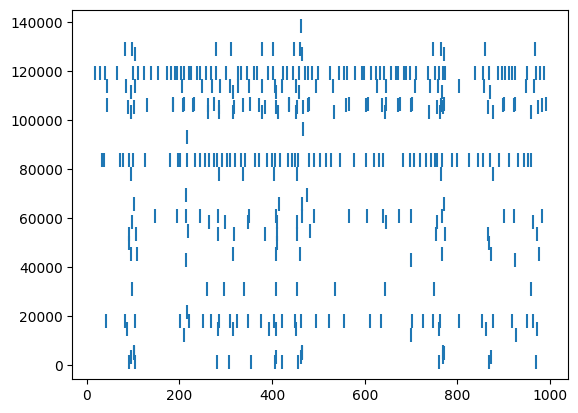

In [11]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [12]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'P9s_100Hz_b', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'P9s_100Hz_b.parquet', compression='brotli')
df_spike = utils.load_exps([config_dirs['path_res']+'P9s_100Hz_b.parquet',])
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9s_100Hz_b
flyid,,
720575940635872101,P9_right,74.0
720575940627652358,P9_left,65.0
720575940613626521,,31.0
720575940633901395,,25.0
720575940631924584,,19.0
720575940623455239,,18.0
720575940632042148,,16.0
720575940631283512,,13.0
720575940640325429,,12.0


In [13]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9s_100Hz_b
flyid,,
720575940626730883,P9_oDN1_left,7.0
720575940620300308,P9_oDN1_right,3.0
720575940629327659,DNa02_right,1.0
720575940604737708,DNa02_left,11.0
